In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка данных
df = pd.read_excel("data for analysis.xlsx", sheet_name="Chart data")

# Замена NaN на 0
df = df.fillna(0)

# Порог для "нуля" (например, всё < 0.0001 → 0)
threshold = 0.0000001

# Столбцы с Defect Rate (автоматический поиск)
defect_rate_cols = [col for col in df.columns if 'Defect Rate' in col]

for col in defect_rate_cols:
    df[col] = df[col].map(lambda x: 0 if abs(x) < threshold else x)

In [64]:
df.head()

,theme_name,Боливия | Bolivia - Defect Rate,Боливия | Bolivia - request,Гватемала | Guatemala - Defect Rate,Гватемала | Guatemala - request,Колумбия | Colombia - Defect Rate,Колумбия | Colombia - request,Перу | Peru - Defect Rate,Перу | Peru - request
0,Cancellations/Skipping::Cancellation due to pa...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000017,1.00000000
1,Cancellations::Driver's fault::Devices (Equipm...,0.00000080,4.00000000,0.00000277,1.00000000,0.00000076,4.00000000,0.00000199,12.00000000
2,Cancellations::Driver's fault::Didn't arrive/r...,0.00035948,1791.00000000,0.00229734,830.00000000,0.00033302,1744.00000000,0.00095955,5773.00000000
3,Cancellations::Driver's fault::Doesn't know tr...,0.00001806,90.00000000,0.00009134,33.00000000,0.00001127,59.00000000,0.00006383,384.00000000
4,Cancellations::Driver's fault::Doesn't know tr...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000017,1.00000000


In [66]:
# 2. Создаем столбец Category с тематиками первого порядка
df['Category'] = df['theme_name'].str.split('::').str[0]  # Первый уровень категории

# 3. Анализ ключевых проблем
# Суммируем обращения и дефекты по категориям
problems = df.groupby('Category').agg({
    'Боливия | Bolivia - request': 'sum',
    'Гватемала | Guatemala - request': 'sum',
    'Колумбия | Colombia - request': 'sum', 
    'Перу | Peru - request': 'sum'
}).reset_index()

# Топ-5 проблем по общему количеству обращений
top_problems = problems.melt(id_vars='Category', var_name='Country', value_name='Requests')
top_problems['Country'] = top_problems['Country'].str.split(' - ').str[0]  # Упрощаем названия стран

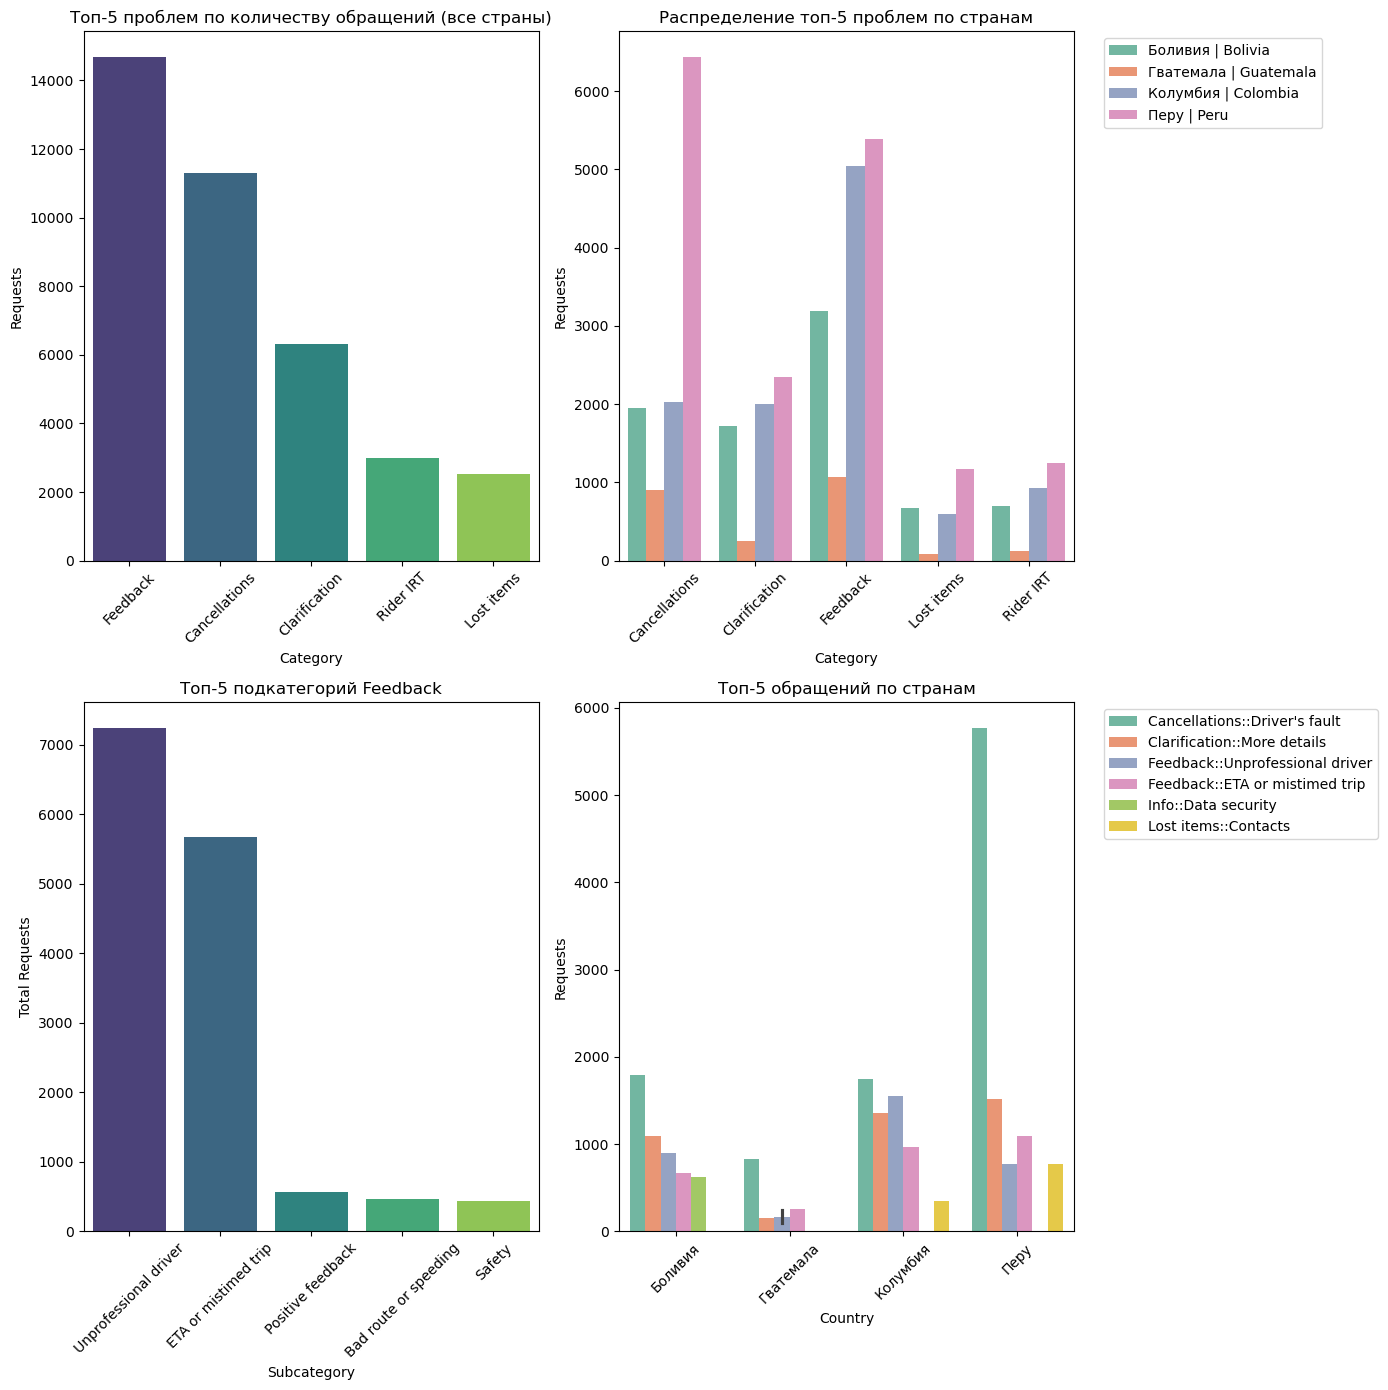

In [70]:
# 4. Визуализация
plt.figure(figsize=(14, 14))

# График 1: Топ-5 проблем
plt.subplot(2, 2, 1)
top5_data = top_problems.groupby('Category')['Requests'].sum().reset_index().sort_values('Requests', ascending=False).head(5)
sns.barplot(
    data=top5_data,
    x='Category',
    y='Requests',
    hue='Category',
    palette='viridis',
    legend=False
)
plt.title('Топ-5 проблем по количеству обращений (все страны)')
plt.xticks(rotation=45)

# График 2: Распределение по странам
plt.subplot(2, 2, 2)
top_5_categories = top_problems.groupby('Category')['Requests'].sum().nlargest(5).index
sns.barplot(
    data=top_problems[top_problems['Category'].isin(top_5_categories)],
    x='Category',
    y='Requests',
    hue='Country',
    palette='Set2'
)
plt.title('Распределение топ-5 проблем по странам')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# График 3: Разбивка категории Feedback на топ-5 подкатегорий
plt.subplot(2, 2, 3)
feedback_df = df[df['Category'] == 'Feedback'].copy()
feedback_df['Subcategory'] = feedback_df['theme_name'].str.split('::').str[1]  # Второй уровень категории

feedback_requests = feedback_df.groupby('Subcategory').agg({
    'Боливия | Bolivia - request': 'sum',
    'Гватемала | Guatemala - request': 'sum',
    'Колумбия | Colombia - request': 'sum',
    'Перу | Peru - request': 'sum'
}).sum(axis=1).reset_index(name='Total Requests')

top5_feedback = feedback_requests.sort_values('Total Requests', ascending=False).head(5)
sns.barplot(
    data=top5_feedback,
    x='Subcategory',
    y='Total Requests',
    hue='Subcategory',
    palette='viridis',
    legend=False
)
plt.title('Топ-5 подкатегорий Feedback')
plt.xticks(rotation=45)

# График 4: Топ-5 обращений в каждой стране
plt.subplot(2, 2, 4)

countries = ['Боливия | Bolivia', 'Гватемала | Guatemala', 'Колумбия | Colombia', 'Перу | Peru']
country_data = []

for country in countries:
    country_col = f"{country} - request"
    top5_country = df.nlargest(5, country_col)[['theme_name', country_col]]
    top5_country['Country'] = country.split(' | ')[0]
    top5_country['Requests'] = top5_country[country_col]
    top5_country['Problem'] = top5_country['theme_name'].str.split('::').str[0] + "::" + top5_country['theme_name'].str.split('::').str[1]
    country_data.append(top5_country)

top5_all_countries = pd.concat(country_data)
sns.barplot(
    data=top5_all_countries,
    x='Country',
    y='Requests',
    hue='Problem',
    palette='Set2'
)
plt.title('Топ-5 обращений по странам')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()